# Multilayer fully-connected Network

1. [The Tasks](#tt) <br>
2. [Loading our Data and Libraries](#ld) <br>
3. [Multilayer Neural Network](#nn) <br>
4. [Plotting the Validation Accuracy](#pn) <br>

***

## The Tasks
<a id="tt" > 

For both networks - the fully-connected and the convolutional one

- Split the data into train, validation and test sets with respectively 3200, 800 and 1000 points.
- Train the network using small random batches of data and monitor the validation accuracy.
- Evaluate and print the test accuracy of the tuned model.


Using the high-level OverFeat features

- Implement a 2-layer fully-connected network with dropout and L2 regularization.

Using the matrix of pixels

- Implement a convolutional neural network.
- Plot the trained weights from the first convolutional layer.

***

## Loading/Preparing our Data and Libraries
<a id="ld" > 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
sns.set()
%matplotlib inline

In [2]:
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())
print('Our data countains {}'.format(cifar4.keys()))

Our data countains dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [3]:
X_of = cifar4['overfeat']
y = cifar4['labels']

# We scale our features since gradient descent is sensitive to the scale of the data
scaler = StandardScaler()
X_of = scaler.fit_transform(X_of)

# Splitting our data into a train- and test set
X_tr, X_te, y_tr, y_te = train_test_split(X_of, y, test_size=1800, random_state=0)

# Further splitting the test set into a test- and validation set
X_val, X_te, y_val, y_te = train_test_split(X_te, y_te, test_size=1000, random_state=0)

print('Train shape:', X_tr.shape)
print('Validation shape:', X_val.shape)
print('Test shape:', X_te.shape)

Train shape: (3200, 4096)
Validation shape: (800, 4096)
Test shape: (1000, 4096)


In [4]:
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n 
    np.random.shuffle(shuffled_idx)
    # Enumerate indexes by steps of batch_size
    # i: e, b, 2b, 3b, 4b, .. where b is the batch size 
    for i in range(0, len(y), batch_size):
    # Batch indexes
        batch_idx = shuffled_idx[i :i+batch_size] 
        yield X[batch_idx], y[batch_idx]

***

## Multilayer Neural Network
<a id="nn" > 

In [5]:
# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype = tf.float32, shape=[None, X_of.shape[1]])
    y = tf.placeholder(dtype = tf.int32, shape=[None])
    
    # Hidden layer with 64 units
    hidden = tf.layers.dense(
        X, 64, activation = tf.nn.relu,  # ReLu
        kernel_initializer = tf.variance_scaling_initializer(scale = 2, seed = 0),
        bias_initializer=tf.zeros_initializer(), 
        name = 'hidden')
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 4, activation = None, #No activation function
        kernel_initializer = tf.variance_scaling_initializer(scale = 1, seed = 0),
        bias_initializer = tf.zeros_initializer(),
        name = 'output') 
    
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse = True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')
   
    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse = True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

In [6]:
with graph.as_default():
    
    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)
    
    # Applying dropout 
    inputs = tf.layers.dropout(X, rate=0.5, seed=0.5, training=training)
    hidden = tf.layers.dropout(hidden, rate=0.5, seed=0.5, training=training) 
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Learning rate placeholder
    lr = tf.placeholder(dtype=tf.float32)
    # Create the optimizer
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    # L2 term
    l2_term_W1 = tf.nn.l2_loss(W1)
    l2_term_W2 = tf.nn.l2_loss(W2)
    
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    
    # Loss function
    loss = mean_ce + alpha * (l2_term_W1 + l2_term_W2)
        
    # Create a training operation
    train_op = gd.minimize(loss)
    
    # Computing predictions/accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [7]:
# Validation Accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(200):
        batch_acc = []
        
        for X_batch,y_batch in get_batches(X_tr, y_tr, 300):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy],
                                     feed_dict={X: X_batch,
                                                y: y_batch, lr: 0.001,
                                                training: True,
                                                alpha: 0.001})
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)
            
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, 
                             feed_dict={X: X_val, 
                                        y: y_val, 
                                        training:False})
        
        valid_acc_values.append(valid_acc)
              
        
        if (epoch+1)%5==0: 
            print('Epoch{} - valid: {:.3f} train: {:.3f} (mean)'.format(epoch+1, 
                                                                    valid_acc, 
                                                                    np.mean(batch_acc)))   
        
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, 
                        feed_dict={X: X_te, 
                                   y: y_te})
    
    print('Accuracy of our Network on the test set: {:.3f}'.format(test_acc))   
    print('Accuracy of our Network on the validation set: {:.3f}'.format(valid_acc))   

    weights_hidden = W1.eval()
    weights_hidden = W2.eval()

Epoch5 - valid: 0.548 train: 0.561 (mean)
Epoch10 - valid: 0.652 train: 0.679 (mean)
Epoch15 - valid: 0.707 train: 0.743 (mean)
Epoch20 - valid: 0.734 train: 0.772 (mean)
Epoch25 - valid: 0.751 train: 0.791 (mean)
Epoch30 - valid: 0.761 train: 0.804 (mean)
Epoch35 - valid: 0.766 train: 0.811 (mean)
Epoch40 - valid: 0.777 train: 0.820 (mean)
Epoch45 - valid: 0.783 train: 0.824 (mean)
Epoch50 - valid: 0.786 train: 0.831 (mean)
Epoch55 - valid: 0.785 train: 0.839 (mean)
Epoch60 - valid: 0.790 train: 0.843 (mean)
Epoch65 - valid: 0.790 train: 0.845 (mean)
Epoch70 - valid: 0.790 train: 0.847 (mean)
Epoch75 - valid: 0.793 train: 0.852 (mean)
Epoch80 - valid: 0.794 train: 0.855 (mean)
Epoch85 - valid: 0.796 train: 0.857 (mean)
Epoch90 - valid: 0.799 train: 0.859 (mean)
Epoch95 - valid: 0.798 train: 0.861 (mean)
Epoch100 - valid: 0.800 train: 0.865 (mean)
Epoch105 - valid: 0.800 train: 0.866 (mean)
Epoch110 - valid: 0.799 train: 0.867 (mean)
Epoch115 - valid: 0.803 train: 0.868 (mean)
Epoch120

***

## Plotting the Validation Accuracy
<a id="pn" > 

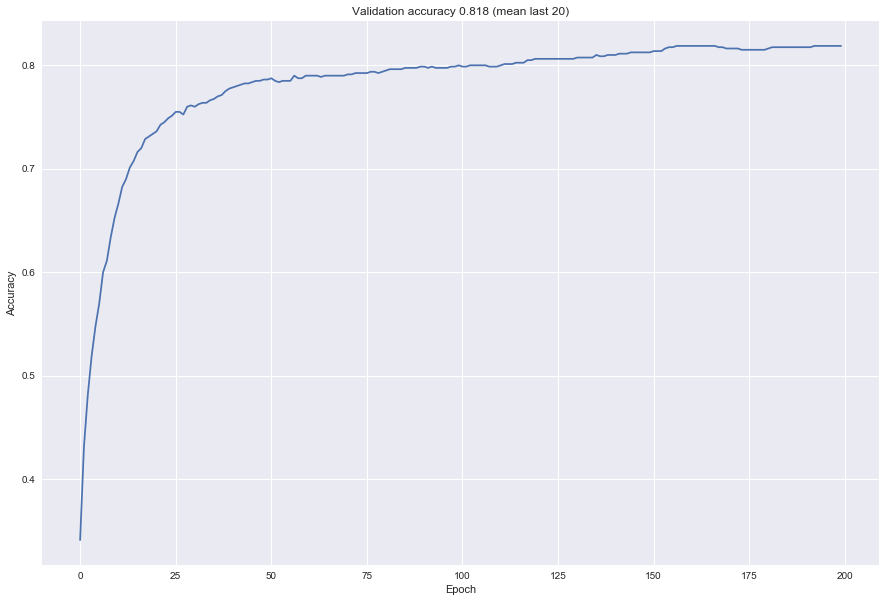

In [8]:
fig = plt.figure(figsize=(15, 10))
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 20)'.format(np.mean(valid_acc_values[-20:])))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()